In [1]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>% 
    group_by(character, episode_number) %>% 
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>% 
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

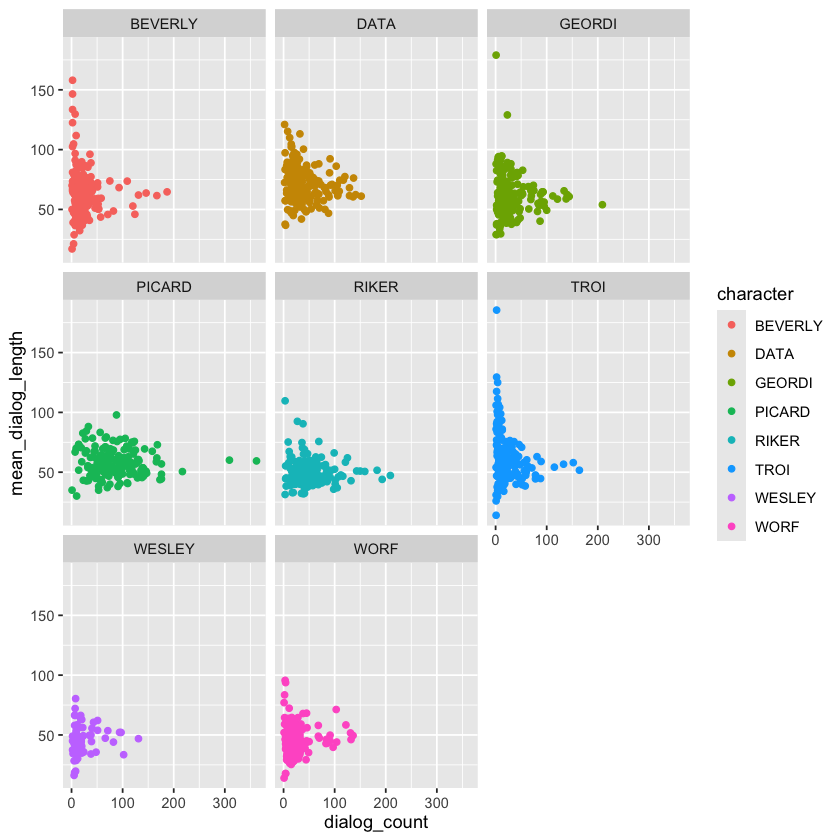

In [2]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + 
    geom_point(aes(color=character)) + 
    facet_wrap(~character)

**Question 1**

From the plots of the characters, we are able to infer several things. First, we are able to see which characters speak the longest based on how their mean length is distributed. From the plots, we see that Wesley and Worf tend to have shorter lines and also speak the most infrequently. We also can infer that Picard and Riker are likely main characters based on their dialog count spanning a large portion of the graph. Finally, we can also see how characters' dialog changes over time. It is clear that Beverly and Troi do not speak very often, but when they do, they have monologues or longer lines.

**Question 2**

In [8]:
## a)

library(dplyr)

beverly_summary <- dialog_len_per_ep %>%
  filter(character == "BEVERLY",
         (episode_number >= 102 & episode_number <= 126) | 
         (episode_number >= 149 & episode_number <= 174)) %>%
  mutate(season = case_when(
    episode_number >= 102 & episode_number <= 126 ~ "Season 1",
    episode_number >= 149 & episode_number <= 174 ~ "Season 3"
  )) %>%
  group_by(season) %>%
  summarize(avg_dialog_length = mean(mean_dialog_length, na.rm = TRUE),
    avg_dialog_count = mean(dialog_count, na.rm = TRUE), .groups = "drop")

beverly_summary

## b)
# We see from the table an increase from Season 1 to Season 3 of Beverly's mean dialog length. While the dialog
# count decreases, she's given opportunities to speak for longer, likely offering more insight into the conversation
# rather than many bursts of short lines.

season,avg_dialog_length,avg_dialog_count
<chr>,<dbl>,<dbl>
Season 1,56.48460,25.40
Season 3,67.04817,19.64


**Question 3**

character,total_words,unique_words,vocab_richness
<chr>,<int>,<int>,<dbl>
WESLEY,7601,2291,0.3014077
WORF,18820,4318,0.2294368
TROI,19450,4187,0.2152699
BEVERLY,22900,4875,0.2128821
DATA,45462,8593,0.1890150
GEORDI,31978,5465,0.1708987
RIKER,41827,6458,0.1543979
PICARD,79214,9272,0.1170500


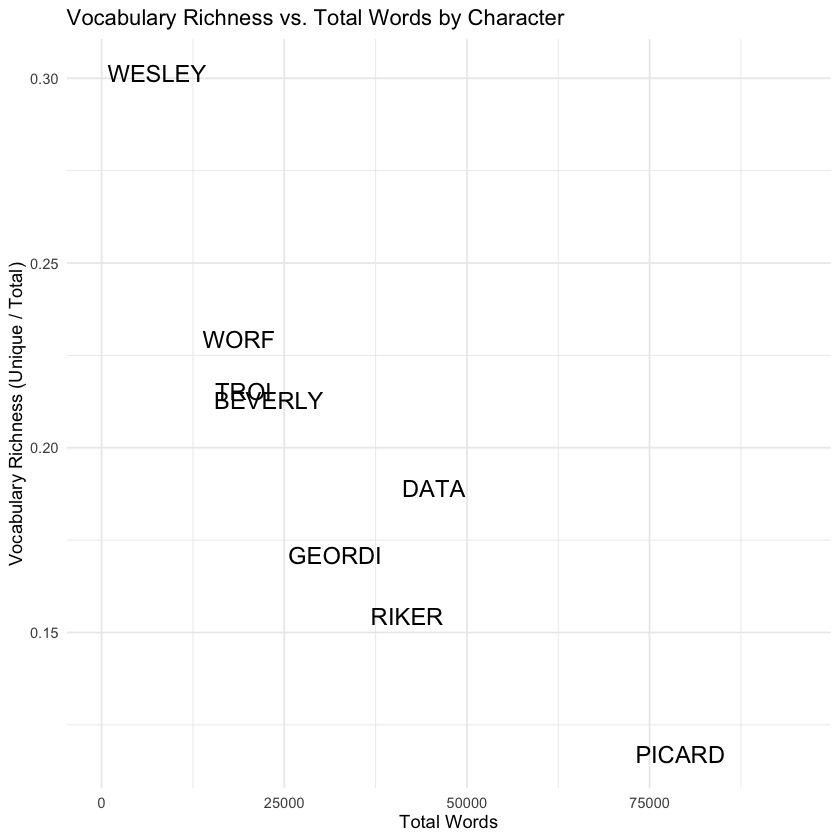

In [16]:
## a)

STOPWORDS <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

library(dplyr)
library(stringr)
library(tidyr)

tokens <- dialogs_fixed %>%
  mutate(word_list = str_split(dialog, "\\s+")) %>%
  unnest(word_list) %>%
  mutate(word = str_remove_all(word_list, "[[:punct:]]"),
    word = str_to_lower(word)) %>%
  filter(word != "", !word %in% STOPWORDS)

## b)

vocab_richness <- tokens %>%
  group_by(character) %>%
  summarize(
    total_words = n(),
    unique_words = n_distinct(word),
    vocab_richness = unique_words / total_words,
    .groups = "drop"
  ) %>%
  arrange(desc(vocab_richness))

vocab_richness

## c)

library(ggplot2)

ggplot(vocab_richness, aes(x = total_words, y = vocab_richness, label = character)) +
  geom_text(size = 5) + labs(title = "Vocabulary Richness vs. Total Words by Character",
    x = "Total Words", y = "Vocabulary Richness (Unique / Total)") + theme_minimal() + 
    theme(legend.position = "none") + xlim(0, max(vocab_richness$total_words) * 1.2)

## d)

# Based on the graph, it is clear that Picard speaks the most. However, his richness is low, likely because he 
# repeats phrases or words begin to be used again because he speaks so much. Wesley has the fewest total words
# but the highest richness. Since he doesn't speak a lot, every word has the chance of being unique for this 
# character. As characters tend to have more words, the less likely they are to have a higher richness score.

**Question 4**

In [22]:
## a)

wesley_counts <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number > 174) %>%
  group_by(episode_number) %>%
  summarize(dialog_count = n(), .groups = "drop") %>%
  arrange(episode_number)

wesley_counts

# The first major gap is between episode 183 and 206, meaning he likely left the show after episode 183.

## b)

last_main_episode <- 183  

wesley_cameos <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number > last_main_episode) %>%
  group_by(episode_number) %>%
  summarize(dialog_count = n(), .groups = "drop") %>%
  arrange(episode_number)

wesley_cameos

## c)

wesley_last_main <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number == 183) %>%
  slice_tail(n = 1)

wesley_last_main

wesley_last_ever <- dialogs_fixed %>%
  filter(character == "WESLEY") %>%
  slice_tail(n = 1)

wesley_last_ever

episode_number,dialog_count
<dbl>,<int>
175,18
176,6
177,9
178,6
179,38
181,2
183,94
206,131
219,71


episode_number,dialog_count
<dbl>,<int>
206,131
219,71
263,18
272,97


episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
183,WESLEY,I can walk.,11


episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
272,WESLEY,"Good-bye, Mom.",14


**Question 5**

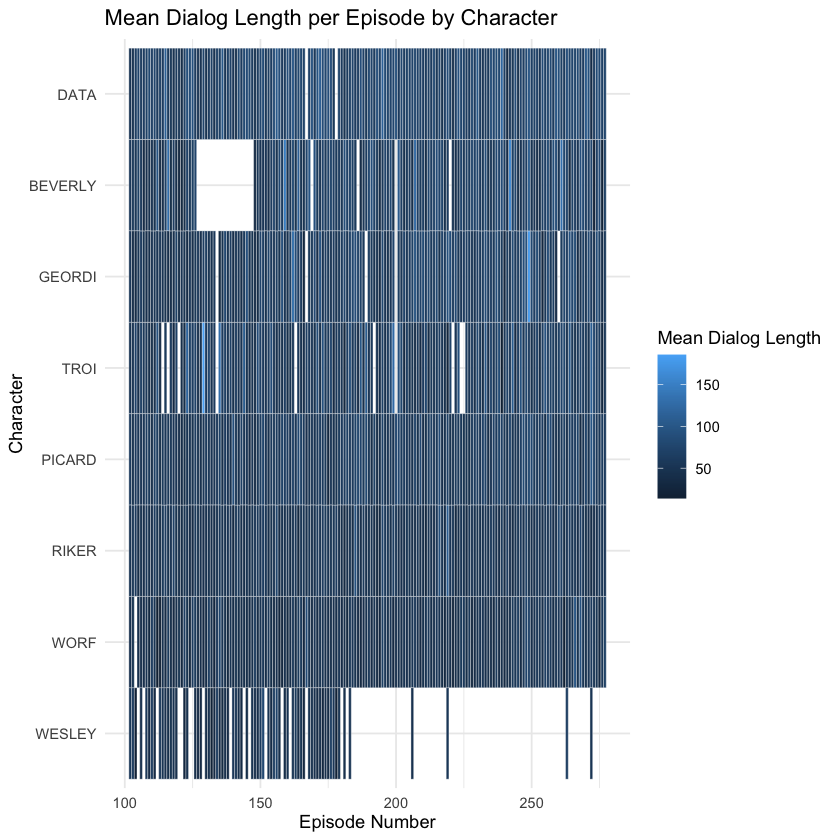

In [26]:
library(dplyr)
library(ggplot2)

character_order <- dialog_len_per_ep %>%
  group_by(character) %>%
  summarize(overall_mean = mean(mean_dialog_length), .groups = "drop") %>%
  arrange(overall_mean) %>%        
  pull(character)

dialog_len_per_ep <- dialog_len_per_ep %>%
  mutate(character = factor(character, levels = character_order))

ggplot(dialog_len_per_ep, aes(x = episode_number, y = character, fill = mean_dialog_length)) +
  geom_tile(color = "white") + labs(title = "Mean Dialog Length per Episode by Character",
    x = "Episode Number", y = "Character", fill = "Mean Dialog Length") + theme_minimal() 